# Content-Based Movie Recommendation System: Model Analysis and User Profile Evaluation

### Introduction

This project builds a movie recommendation system that suggests movies based on their details like title, director, cast, and genre. It uses Bernoulli Naive Bayes, Multinomial Naive Bayes, and Random Forest classifiers. 

It analyzes these models by tuning their parameters, creates user profiles, and identifies the top words for each user in each genre.

### Dataset

The dataset contains 2,000 movies across 8 genres: Animation, Comedy, Drama, Family, Horror, Romance, Sci-Fi, and Thriller. Each movie entry includes details such as title, release year, director, and main actors. The data is stored in TSV files, with each genre having a separate file.  

Additionally, the project creates user profiles based on their genre preferences. It analyzes the most important words for each user in every genre to understand their interests and improve recommendations.

The key steps involved in this project are:  

1. **Data Preprocessing**:  
   - Loading movie datasets categorized by genre.  
   - Creating a unified document representation for each movie.  

2. **Text Classification for Genre Prediction**:  
   - Using **Bernoulli Naive Bayes** and **Multinomial Naive Bayes** classifiers to categorize movies into genres based on textual features.  

3. **Building the Recommender System**:  
   - Leveraging the trained classifier to predict genres for unseen movies.  
   - Computing movie similarity scores based on text data and genre labels.  
   - Generating recommendations based on similarity metrics.  

4. **Evaluation and Analysis**:  
   - Assessing model performance using accuracy, precision, recall, and F1-score.  
   - Comparing different classification techniques to identify the most effective approach.  


In [1]:
import os
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
genres=['animation', 'comedy', 'drama', 'family', 'horror', 'romance', 'sci-fi', 'thriller']
dataframes=[]
for g in genres:
    file=os.path.join('dataset',f'{g}.tsv')
    df=pd.read_csv(file,sep='\t')
    dataframes.append(df)
movies=pd.concat(dataframes,ignore_index=True)
movies['document'] = movies.apply(lambda row: ' '.join(row.drop('Genre').values.astype(str)), axis=1)
movies['document'] = movies['document'].fillna('')

print(movies['document'])

0       Moon Castle: The Space Adventure 2011 James Ch...
1       Inimey Nangathan 2007 Venky Babu nan Vichu, Va...
2       The Wild Thornberrys Movie 2002 Cathy Malkasia...
3       Race for Your Life, Charlie Brown 1977 Phil Ro...
4       Boonie Bears: Entangled Worlds 2017 Ding Liang...
                              ...                        
1995    Half Light 2006 Craig Rosenberg Demi Moore, Ha...
1996    Magic Magic 2013 Sebastián Silva Juno Temple, ...
1997    Deadpool 2016 Tim Miller Ryan Reynolds\r\nT.J....
1998    Out of the Dark 2015 Lluís Quílez Scott Speedm...
1999    Awake 2007 Joby Harold Hayden Christensen, Jes...
Name: document, Length: 2000, dtype: object


In the below cells, I have preprocessed the data and applied both Bernoulli and Multinomial Naive Bayes model. These were the steps I performed:

- As the regex might remove too many characters, I am adjusting the `re.sub()` to include the special characters such as `!,&,-,',.,`and `:`. This has increased the model's accuracy.
- To improve the evaluation, I will be using the `cross_val_score` function.
-  Lowercase Conversion - Converting all letters to lowercase ensures consistency of the data
-  Selectively retaining special characters - This may help in better genre classification
-  Tokenization - This converts the text into induvidual words.
-  Removal of stopwords - This step removed the common words that have no individual meaning. This reduces noise.
-  Stemming and Lemmatization - Performing both stemming and lemmatization together improved the accuracy to a great level. This reduced each word to its root form hence making different forms of a word is treated the same.

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# For lemmatizer
nltk.download('wordnet')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Lemmatizer
lemmatizer=WordNetLemmatizer()   

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    # Retaining some special characters for better genre classificaation
    text = re.sub(r"[^\w\s!&\-'.:]", '', text) 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [ps.stem(word) for word in tokens]
    # Lemmatizing words in addition to stemming 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]   
    
    return ' '.join(tokens)

# Apply preprocessing to each document
movies['document'] = movies['document'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to C:\Users\Yatindran
[nltk_data]     Sathish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Yatindran
[nltk_data]     Sathish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Yatindran
[nltk_data]     Sathish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yatindran
[nltk_data]     Sathish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 140)
print(movies['document'])

0       moon castl : space adventur 2011 jame choo zu liqe zhang lin deng yute liang ying xie weitong gao quansheng zhao na plot follow goat go ...
1       inimey nangathan 2007 venki babu nan vichu varadhu vaithi govind four friend earn livelihood kathakalakshepam . want becom rich famou . ...
2       wild thornberri movi 2002 cathi malkasian jeff mcgrath lacey chabert tom kane tim curri ice-t 12-year-old eliza thornberri play famili c...
3       race life charli brown 1977 phil roman bill melendez duncan watson bill melendez gail davi stuart brotman peanut gang head camp remot so...
4       booni bear : entangl world 2017 ding liang shang wenji bao chunlai sun jianhong booni bear gang da ya big vinc small yukun tri stop cath...
                                                                           ...                                                                     
1995    half light 2006 craig rosenberg demi moor han matheson rachel carlson moor success american murder myste

### Bernoulli and Multinomial Naive Bayes Model

In [5]:
# Changing the value of max_features to boost accuracy
vectorizer = CountVectorizer(max_features=15000)    

X=vectorizer.fit_transform(movies['document'])
y=movies['Genre']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

bnb=BernoulliNB()
mnb=MultinomialNB()

bnb.fit(X_train, y_train)
mnb.fit(X_train, y_train)

print(bnb)
print(mnb)

BernoulliNB()
MultinomialNB()


In [6]:
# Predicting the categories of the test set
y_pred_bnb=bnb.predict(X_test)
y_pred_mnb=mnb.predict(X_test)

print('Bernoulli NB')
# Printing accuracy and classification report of bnb
print(accuracy_score(y_test, y_pred_bnb))
print(classification_report(y_test, y_pred_bnb))

print('Multinomial NB')
# Printing accuracy and classification report of mnb
print(accuracy_score(y_test, y_pred_mnb))
print(classification_report(y_test, y_pred_mnb))

Bernoulli NB
0.5275
              precision    recall  f1-score   support

   animation       0.66      0.49      0.56        47
      comedy       0.81      0.23      0.36        57
       drama       0.36      0.70      0.48        50
      family       0.75      0.53      0.62        45
      horror       0.62      0.63      0.63        41
     romance       0.40      0.70      0.51        47
      sci-fi       0.76      0.60      0.67        62
    thriller       0.43      0.39      0.41        51

    accuracy                           0.53       400
   macro avg       0.60      0.53      0.53       400
weighted avg       0.60      0.53      0.53       400

Multinomial NB
0.56
              precision    recall  f1-score   support

   animation       0.65      0.43      0.51        47
      comedy       0.51      0.44      0.47        57
       drama       0.45      0.44      0.44        50
      family       0.65      0.67      0.66        45
      horror       0.60      0.68     

### Comparing metrics of BNB and MNB

Bernoulli Naive Bayes - Accuracy: 0.5275, Precision: 0.5907, Recall: 0.5275, F1-Score: 0.5334
Multinomial Naive Bayes - Accuracy: 0.5690, Precision: 0.5745, Recall: 0.5690, F1-Score: 0.5661




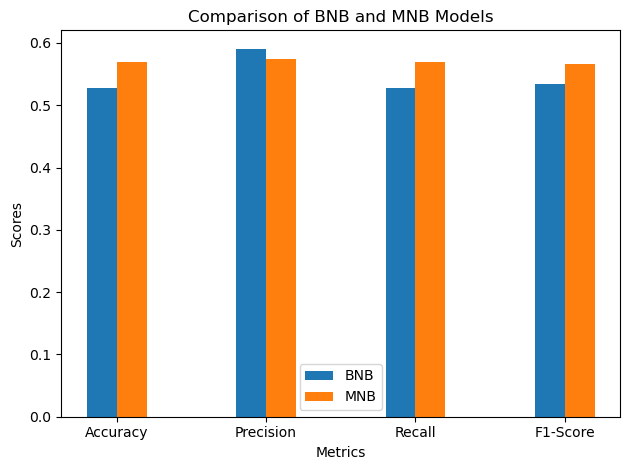

In [7]:
# Bernoulli Naive Bayes (BNB)
bnb_accuracy=cross_val_score(bnb, X, y, cv=5, scoring='accuracy')
bnb_precision=cross_val_score(bnb, X, y, cv=5, scoring='precision_macro')
bnb_recall=cross_val_score(bnb, X, y, cv=5, scoring='recall_macro')
bnb_f1=cross_val_score(bnb, X, y, cv=5, scoring='f1_macro')

# Multinomial Naive Bayes (MNB)
# Usage of cross_val_score() for cross validation
mnb_accuracy=cross_val_score(mnb, X, y, cv=5, scoring='accuracy')
mnb_precision=cross_val_score(mnb, X, y, cv=5, scoring='precision_macro')
mnb_recall=cross_val_score(mnb, X, y, cv=5, scoring='recall_macro')
mnb_f1=cross_val_score(mnb, X, y, cv=5, scoring='f1_macro')

# Printing the results
print(f"Bernoulli Naive Bayes - Accuracy: {bnb_accuracy.mean():.4f}, Precision: {bnb_precision.mean():.4f}, Recall: {bnb_recall.mean():.4f}, F1-Score: {bnb_f1.mean():.4f}")
print(f"Multinomial Naive Bayes - Accuracy: {mnb_accuracy.mean():.4f}, Precision: {mnb_precision.mean():.4f}, Recall: {mnb_recall.mean():.4f}, F1-Score: {mnb_f1.mean():.4f}\n\n")

# Plotting the results
metrics=['Accuracy', 'Precision', 'Recall', 'F1-Score']
bnb_results=[bnb_accuracy.mean(), bnb_precision.mean(), bnb_recall.mean(), bnb_f1.mean()]
mnb_results=[mnb_accuracy.mean(), mnb_precision.mean(), mnb_recall.mean(), mnb_f1.mean()]

x=np.arange(len(metrics))
width=0.2
fig,axi=plt.subplots()
axi.bar(x-width/2, bnb_results, width, label='BNB')
axi.bar(x+width/2, mnb_results, width, label='MNB')
axi.set_xlabel('Metrics')
axi.set_ylabel('Scores')
axi.set_title('Comparison of BNB and MNB Models')
axi.set_xticks(x)
axi.set_xticklabels(metrics)
axi.legend()

fig.tight_layout()

plt.show()

### Conclusion from using BNB and MNB model:

As we can clearly see, MNB method is superior than BNB as we can see that it performs better than BNB in almost all metrics.

Although BNB has a higher precision, the overall performance of MNB makes it the preferred model for this classification task.

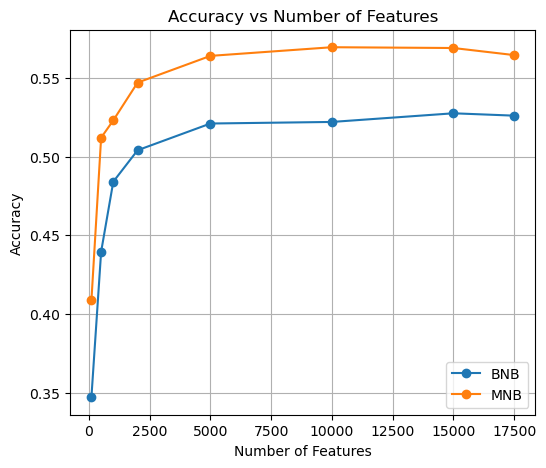

BNB Results:
Features   100        500        1000       2000       5000       10000      15000      17500     
accuracy   0.3470     0.4395     0.4840     0.5040     0.5210     0.5220     0.5275     0.5260    
precision  0.3868     0.5007     0.5378     0.5640     0.5835     0.5873     0.5907     0.5882    
recall     0.3470     0.4395     0.4840     0.5040     0.5210     0.5220     0.5275     0.5260    
f1         0.3367     0.4402     0.4885     0.5105     0.5285     0.5293     0.5334     0.5316    

MNB Results:
Features   100        500        1000       2000       5000       10000      15000      17500     
accuracy   0.4085     0.5120     0.5230     0.5470     0.5640     0.5695     0.5690     0.5645    
precision  0.4107     0.5170     0.5282     0.5510     0.5706     0.5788     0.5745     0.5698    
recall     0.4085     0.5120     0.5230     0.5470     0.5640     0.5695     0.5690     0.5645    
f1         0.4045     0.5096     0.5217     0.5457     0.5627     0.5676     0.566

In [8]:
# Defining a range of max_features values to test
max_features_values = [100, 500, 1000, 2000, 5000, 10000, 15000,17500]

# Dictionaries to store results
bnb_results={'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
mnb_results={'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Looping over different values of max_features
for max_features in max_features_values:
    vectorizer=CountVectorizer(max_features=max_features)
    X=vectorizer.fit_transform(movies['document'])
    y=movies['Genre']

    # Bernoulli Naive Bayes
    bnb_accuracy=cross_val_score(bnb, X, y, cv=5, scoring='accuracy').mean()
    bnb_precision=cross_val_score(bnb, X, y, cv=5, scoring='precision_macro').mean()
    bnb_recall=cross_val_score(bnb, X, y, cv=5, scoring='recall_macro').mean()
    bnb_f1=cross_val_score(bnb, X, y, cv=5, scoring='f1_macro').mean()

    # Multinomial Naive Bayes 
    mnb_accuracy = cross_val_score(mnb, X, y, cv=5, scoring='accuracy').mean()
    mnb_precision = cross_val_score(mnb, X, y, cv=5, scoring='precision_macro').mean()
    mnb_recall = cross_val_score(mnb, X, y, cv=5, scoring='recall_macro').mean()
    mnb_f1 = cross_val_score(mnb, X, y, cv=5, scoring='f1_macro').mean()

    # Storing results
    bnb_results['accuracy'].append(bnb_accuracy)
    bnb_results['precision'].append(bnb_precision)
    bnb_results['recall'].append(bnb_recall)
    bnb_results['f1'].append(bnb_f1)
    mnb_results['accuracy'].append(mnb_accuracy)
    mnb_results['precision'].append(mnb_precision)
    mnb_results['recall'].append(mnb_recall)
    mnb_results['f1'].append(mnb_f1)

plt.figure(figsize=(6,5))
plt.plot(max_features_values, bnb_results['accuracy'], label='BNB', marker='o')
plt.plot(max_features_values, mnb_results['accuracy'], label='MNB', marker='o')
plt.title('Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("BNB Results:")
print(f"{'Features':<10} {'100':<10} {'500':<10} {'1000':<10} {'2000':<10} {'5000':<10} {'10000':<10} {'15000':<10} {'17500':<10}")
for metric in bnb_results:
    print(f"{metric:<10} {' '.join(f'{bnb_results[metric][i]:<10.4f}' for i in range(len(max_features_values)))}")

print("\nMNB Results:")
print(f"{'Features':<10} {'100':<10} {'500':<10} {'1000':<10} {'2000':<10} {'5000':<10} {'10000':<10} {'15000':<10} {'17500':<10}")
for metric in mnb_results:
    print(f"{metric:<10} {' '.join(f'{mnb_results[metric][i]:<10.4f}' for i in range(len(max_features_values)))}")

### Visualization

By plotting the Accuracy vs Number of Features, we can see above that the value of accuracy is highest when the number of features is 15000 and it decreases at 17500.

For BNB, the highest achieved accuracy is 0.5270 at num of features is 15000.
For MNB, the highest achieved accuracy is 0.5695 at num of features is 15000.

## Random Forest Classifier

- As seen below, I will be using random forest as the problem is a multiclass problem and random forest would be a good method to address this.
- I have tuned the max features to 5000 and the n_estimators to 200 which gives an accuracy of 0.5910. After this point, the accuracy decreases.
- In comparison to BNB and MNB, which have an accuracy of 0.5270 and 0.5695 respectively with max features of 15000, The random forest model has slightly better accuracy. 

In [9]:
# Initialize dictionaries to store Random Forest results
rf_results={'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Setting Max Features value as 5000
vectorizer_rf=CountVectorizer(max_features=5000) 

# Uncomment the below line and comment the above line to see the decrease of accuracy
#vectorizer_rf=CountVectorizer(max_features=10000)

X=vectorizer_rf.fit_transform(movies['document'])
y=movies['Genre']

# Random Forest (Setting n estimators as 200)
rf=RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1) 

# Training the data
rf.fit(X,y)

rf_accuracy=cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean()
rf_precision=cross_val_score(rf, X, y, cv=5, scoring='precision_macro').mean()
rf_recall=cross_val_score(rf, X, y, cv=5, scoring='recall_macro').mean()
rf_f1=cross_val_score(rf, X, y, cv=5, scoring='f1_macro').mean()

print('Random Forest Model Metrics:\n')
print(f"{'Accuracy:':<10} {rf_accuracy:.4f}")
print(f"{'Precision:':<10} {rf_precision:.4f}")
print(f"{'Recall:':<10} {rf_recall:.4f}")
print(f"{'F1:':<10} {rf_f1:.4f}")

Random Forest Model Metrics:

Accuracy:  0.5785
Precision: 0.5829
Recall:    0.5785
F1:        0.5699


## User Profile Analysis

### Finding top words by Genre for each User

- I have defined a 'User 1', 'User 2' and 'User 3' profile and printed top 20 words for each genre.

In [10]:
train_data = []
test_data = []
train_labels = []
test_labels = []

for i in range(0, len(movies), 250):
    train_data.append(movies['document'][i:i+150])
    test_data.append(movies['document'][i+150:i+200])
    train_labels.append(movies['Genre'][i:i+150])
    test_labels.append(movies['Genre'][i+150:i+200])

train_data=pd.concat(train_data).reset_index(drop=True)
test_data=pd.concat(test_data).reset_index(drop=True)
train_labels=pd.concat(train_labels).reset_index(drop=True)
test_labels=pd.concat(test_labels).reset_index(drop=True)

# Vectorize the training data
tfidf = TfidfVectorizer()
tfidf_matrix_train = tfidf.fit_transform(train_data)

# Train the Random Forest model
rf.fit(tfidf_matrix_train,train_labels)

predicted_genres = rf.predict(tfidf_matrix_train)

# Creating user profile
def create_profile(liked_movies, vectorizer):
    combined_text=' '.join(liked_movies)
    tfidf_vec=vectorizer.transform([combined_text])
    return tfidf_vec

# Load user profiles
user1=pd.read_csv('user1.tsv',sep='\t',header=None,index_col=0,names=['Genre','Keywords'])
user2=pd.read_csv('user2.tsv',sep='\t',header=None,index_col=0,names=['Genre','Keywords'])

#Simulating user interests
def get_liked_movies(user,predicted_genres,train_data):
    liked_movies={}
    for genre in genres:
        if genre in user.index:
            keywords = user.loc[genre,'Keywords'].lower().split()
            liked_movies[genre] = []
            for i, doc in enumerate(train_data):
                if predicted_genres[i] == genre:
                    if any(keyword in doc for keyword in keywords):
                        liked_movies[genre].append(doc)
    return liked_movies

# Get liked movies for both users
liked_movies_user1=get_liked_movies(user1, predicted_genres, train_data)
liked_movies_user2=get_liked_movies(user2, predicted_genres, train_data)

# Create user profiles
user1_tfidf={genre:create_profile(liked_movies, tfidf) for genre,liked_movies in liked_movies_user1.items() if liked_movies}
user2_tfidf={genre:create_profile(liked_movies, tfidf) for genre,liked_movies in liked_movies_user2.items() if liked_movies}

# Print top 20 words for each genre in the user profiles
def print_top_words(user_tfidf,vectorizer,user):
    for genre,tfidfv in user_tfidf.items():
        feature_array=vectorizer.get_feature_names_out()
        tfidf_sorting=tfidfv.toarray().flatten().argsort()[::-1]
        top_words=[feature_array[i] for i in tfidf_sorting[:20]]
        print(f"Top words for {user} in {genre} genre:\n {top_words}\n")

print_top_words(user1_tfidf,tfidf,'User 1')
print_top_words(user2_tfidf,tfidf,'User 2')

# Defining user 3
user3={'animation': 'cartoon hero','comedy': 'laugh joke humor','drama': 'emotional life struggle','family': 'kids fun family','horror': 'scary monster',
       'romance': 'love relationship','sci-fi': 'future technology','thriller': 'suspense tension'}

# Convert user3 profile to dataframe
user3_df=pd.DataFrame.from_dict(user3,orient='index',columns=['Keywords'])

# Get liked movies for User 3
liked_movies_user3=get_liked_movies(user3_df, predicted_genres, train_data)

# Create user profile for User 3
user3_tfidf={genre: create_profile(liked_movies, tfidf) for genre, liked_movies in liked_movies_user3.items() if liked_movies}

# Print top 20 words for each genre in User 3's profile
print_top_words(user3_tfidf,tfidf,'User 3')

Top words for User 1 in animation genre:
 ['tigger', 'ref', 'shrek', 'smurf', 'mcqueen', 'bear', 'find', 'back', 'use', 'anim', 'tri', 'jimmi', 'spirit', 'friend', 'jerri', 'adora', 'arlo', 'make', 'princess', 'roo']

Top words for User 1 in comedy genre:
 ['sanzang', 'doc', 'oh', 'wade', 'boov', 'ben', 'burt', 'ruth', 'greg', 'mac', 'frank', 'jame', 'brad', 'derrick', 'lou', 'val', 'madea', 'jones', 'nick', 'get']

Top words for User 1 in family genre:
 ['christma', 'harri', 'duck', 'grinch', 'jake', 'bombay', 'kri', 'dumbledor', 'jack', 'santa', 'team', 'charli', 'ginni', 'orion', 'slughorn', 'hockey', 'draco', 'abbi', 'game', 'thoma']

Top words for User 1 in horror genre:
 ['koyomi', 'vampir', 'mullet', 'joseph', 'abbi', 'barnaba', 'kill', 'tsubasa', 'priest', 'ghost', 'shark', 'max', 'shot', 'hous', 'death', 'kiss', 'mishima', 'heidi', 'wallac', 'find']

Top words for User 1 in romance genre:
 ['takeo', 'danc', 'rinko', 'nick', 'suna', 'xiang', 'katey', 'kate', 'love', 'justin', '

### Inference:

- As we can see in the output below, the top words for most genres seems reasonable. 
- Some examples are, Horror has kill, vampire, priest, ghost. Sci-Fi has alien, clone, robot.